AFML Chapter 7 Snippet

7.1 Purging Observation in the training set

In [2]:
import pandas as pd
import numpy as np

def get_train_times(train_times:pd.Series, test_times:pd.Series)-> pd.Series:
    '''
    test_times와 겹치는 것을 제외한 train_times를 반환하는 함수
    '''
    ret=train_times.copy(deep=True)
    for t_in, t_out in test_times.items():
        df0=ret[(t_in<=ret.index) & (ret.index<=t_out)].index # train이 test에서 시작
        df1=ret[(t_in<=ret) & (ret<=t_out)].index # train이 test에서 끝
        df2=ret[(ret.index<=t_in) & (t_out<=ret)].index # train이 test를 포함
        ret=ret.drop(df0.union(df1).union(df2))
    return ret

7.2 Embargo on traing observations

original train1: 670
original train2: 224
train1 after embargo: 650
train2 after embargo: 204


/var/folders/4t/tqsscz0s6wn8sp8kh0264n680000gn/T/ipykernel_79404/2048058959.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mbrg=pd.concat([mbrg, pd.Series(times[-1], index=times[-step:])])


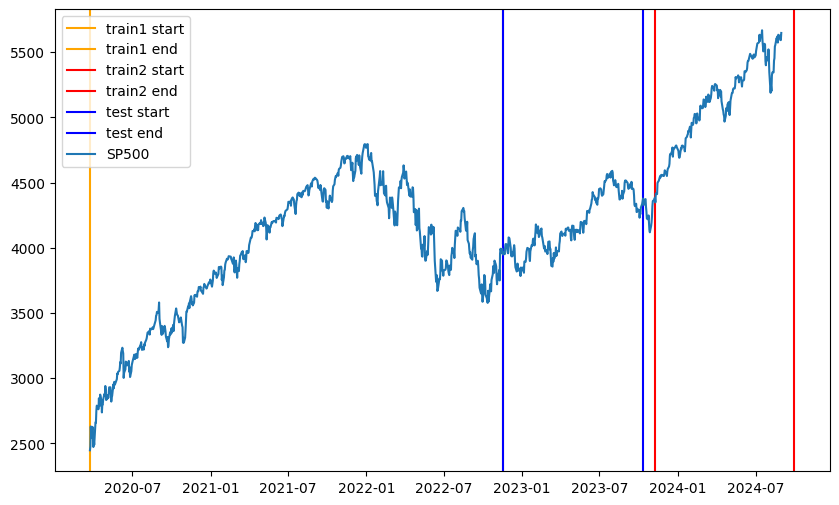

In [ ]:
def get_embargo_times(times:pd.DatetimeIndex, pct_embargo:float)-> pd.Series:
    '''
    times의 pct_embargo 비율만큼을 제외한 times를 반환하는 함수
    return pd.Series
    - index: times의 index
    - values: embargo된 times
    '''
    step=int(len(times)*pct_embargo)
    if step==0:
        return pd.Series(times, index=times)
    else:
        mbrg=pd.Series(times[step:], index=times[:-step])
        mbrg=pd.concat([mbrg, pd.Series(times[-1], index=times[-step:])])
        return mbrg
    
min_df=pd.read_csv('./GSPC.INDX_1m.csv', index_col=0, parse_dates=True)
sp500=min_df.resample('1D').last().dropna()
t1=pd.Series(index=sp500.index[:-20], data=sp500.index[20:]) # [t_in, t_out)
X_train1=t1[:int(len(t1)*0.6)]
X_test=t1[int(len(t1)*0.6):int(len(t1)*0.8)]
X_train2=t1[int(len(t1)*0.8):]
print('original train1:', len(X_train1))
print('original train2:', len(X_train2))

mbrg=get_embargo_times(X_test, 0.1)
test_times=pd.Series(mbrg[X_test.index[-1]], index=[X_test.index[0]])
train_times_1=get_train_times(X_train1, pd.Series(X_test.index[-1], index=[X_test.index[0]]))
train_times_2=get_train_times(X_train2, test_times)
print('train1 after purge:', len(train_times_1))
print('train2 after purge+embargo:', len(train_times_2))
test_times=t1.loc[X_test.index[0]:X_test.index[-1]].index
import matplotlib.pyplot as plt
sp_max=max(sp500.loc[t1.index, 'Close'].values)
plt.figure(figsize=(10, 6))
plt.axvline(x=train_times_1.index[0],ymin=0, ymax=sp_max ,color='orange', label='train1 start')
plt.axvline(x=train_times_1.iloc[-1],ymin=0, ymax=sp_max, color='orange', label='train1 end')
plt.axvline(x=train_times_2.index[0],ymin=0, ymax=sp_max ,color='red', label='train2 start')
plt.axvline(x=train_times_2.iloc[-1],ymin=0, ymax=sp_max, color='red', label='train2 end')
plt.axvline(x=test_times[0], ymin=0, ymax=sp_max, color='blue', label='test start')
plt.axvline(x=test_times[-1],ymin=0, ymax=sp_max,  color='blue', label='test end')
plt.plot(t1.index, sp500.loc[t1.index, 'Close'], label='SP500')
plt.legend()
plt.show()

7.3 Cross Validation class when observations overlap

In [ ]:
from sklearn.model_selection import KFold

class PurgedKFold(KFold):
    '''
    기본 KFold를 상속받아서 purge를 포함한 KFold를 구현한 클래스
    '''
    def __init__(self, n_splits=5, t1:pd.Series=None, pct_embargo=0.):
        if not isinstance(t1, pd.Series):
            raise ValueError('t1 must be a pandas Series')
        super(PurgedKFold, self).__init__(n_splits=n_splits, shuffle=False, random_state=None)
        self.t1=t1
        self.pct_embargo=pct_embargo

    def split(self, X, y=None, groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X.index must be same as t1.index')
        indices=np.arange(len(X))
        mbrg=int(len(X)*self.pct_embargo)
        test_starts=[(i[0], i[-1]+1) for i in np.array_split(indices, self.n_splits)]
        for t_in, t_out in test_starts:
            test_start=self.t1.index[t_in]
            test_indices=indices[t_in:t_out]
            max_t1_idx=self.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=test_start].index)
            if max_t1_idx<len(X): # right train with embargo
                train_indices=np.concatenate([train_indices, indices[max_t1_idx+mbrg:]])
            yield train_indices, test_indices

def cv_score(clf, X, y, sample_weight, scoring='neg_log_loss', t1:pd.Series=None, cv=None, cv_gen=None, pct_embargo:float=None):
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise ValueError('scoring must be neg_log_loss or accuracy')
    from sklearn.metrics import log_loss, accuracy_score
    if cv_gen is None:
        cv_gen=PurgedKFold(n_splits=cv, t1=t1, pct_embargo=pct_embargo)
    score=[]
    for train, test in cv_gen.split(X=X):
        fit=clf.fit(X.iloc[train,:], y.iloc[train], sample_weight=sample_weight.iloc[train].values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X.iloc[test, :])
            score_=-log_loss(y.iloc[test], prob, sample_weight=sample_weight.iloc[test].values, labels=clf.classes_)
        elif scoring=='accuracy':
            pred=fit.predict(X.iloc[test, :])
            score_=accuracy_score(y.iloc[test], pred, sample_weight=sample_weight.iloc[test].values)
        score.append(score_)
    return np.array(score)

